In [3]:
from datetime import datetime
import yfinance as yf

In [4]:
start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)

df = yf.download(
    'SPY',
    start=start_date,
    end=end_date,
)

[*********************100%%**********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,121.559998,121.760002,119.900002,120.300003,83.623383,55748000
2005-01-04,120.459999,120.540001,118.440002,118.830002,82.601570,69167600
2005-01-05,118.739998,119.250000,118.000000,118.010002,82.031563,65667300
2005-01-06,118.440002,119.150002,118.260002,118.610001,82.448631,47814700
2005-01-07,118.970001,119.230003,118.129997,118.440002,82.330452,55847700


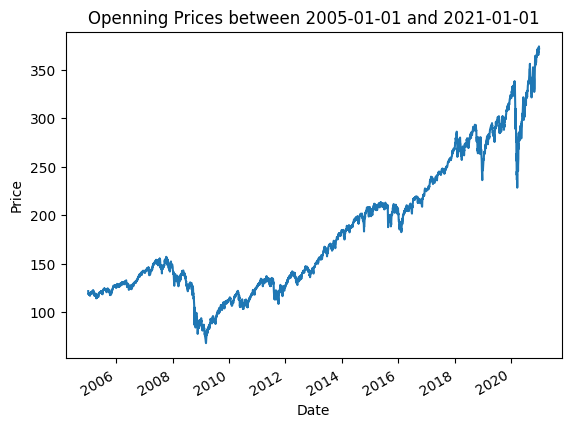

In [9]:
import matplotlib.pyplot as plt
plt.title('Openning Prices between {} and {}'.format(
    start_date.date().isoformat(),
    end_date.date().isoformat()
))
df['Open'].plot()
plt.ylabel('Price')
plt.xlabel('Date');

In [10]:
df1 = df.reset_index().resample('W', on="Date")['Open'].mean()

In [11]:
df1

Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
                 ...    
2020-12-06    365.444000
2020-12-13    367.577997
2020-12-20    369.754004
2020-12-27    367.384995
2021-01-03    372.417496
Freq: W-SUN, Name: Open, Length: 835, dtype: float64

In [12]:
df1 = df1[df1.index.week < 53]
df1

/var/folders/r8/__hqjl2n5j5_wf6w5j15gn300000gn/T/ipykernel_61210/648574031.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df1 = df1[df1.index.week < 53]


Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
                 ...    
2020-11-29    361.114998
2020-12-06    365.444000
2020-12-13    367.577997
2020-12-20    369.754004
2020-12-27    367.384995
Name: Open, Length: 832, dtype: float64

In [14]:
df1 = df1.asfreq('W').fillna(method='ffill')
df1

Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
                 ...    
2020-11-29    361.114998
2020-12-06    365.444000
2020-12-13    367.577997
2020-12-20    369.754004
2020-12-27    367.384995
Freq: W-SUN, Name: Open, Length: 834, dtype: float64

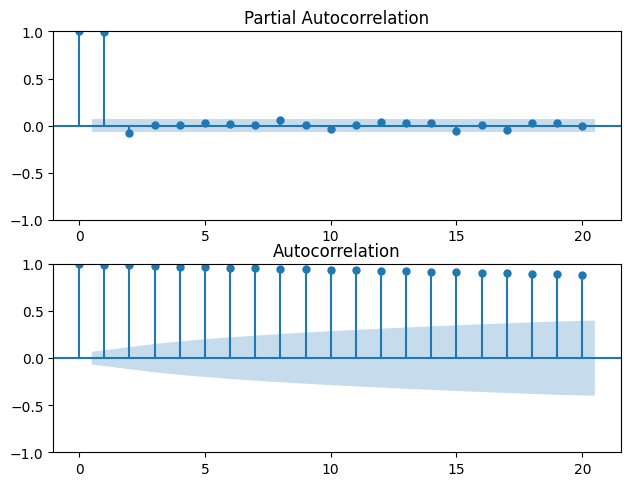

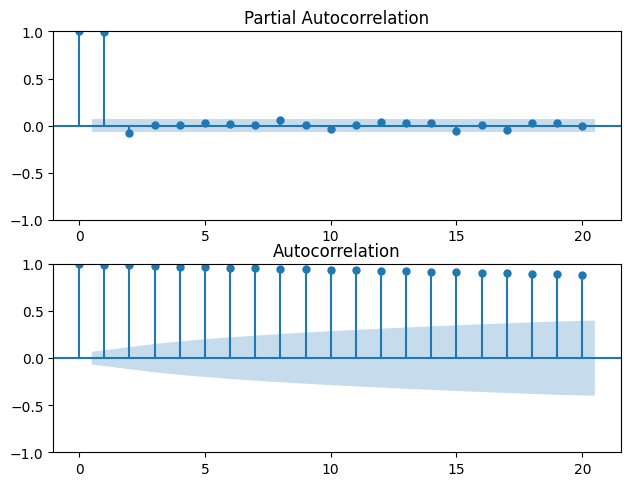

In [18]:
import statsmodels.api as sm
fig, axs = plt.subplots(2)
fig.tight_layout()
sm.graphics.tsa.plot_pacf(df1, lags=20, ax=axs[0])
sm.graphics.tsa.plot_acf(df1, lags=20, ax=axs[1])

statsmodels can be used to look at seasonality and trend from the time-series

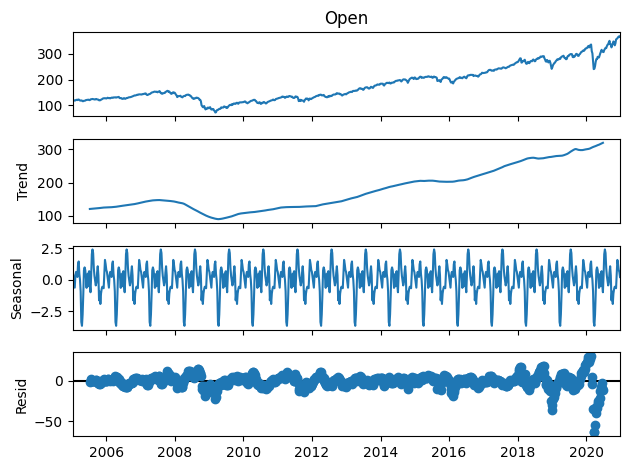

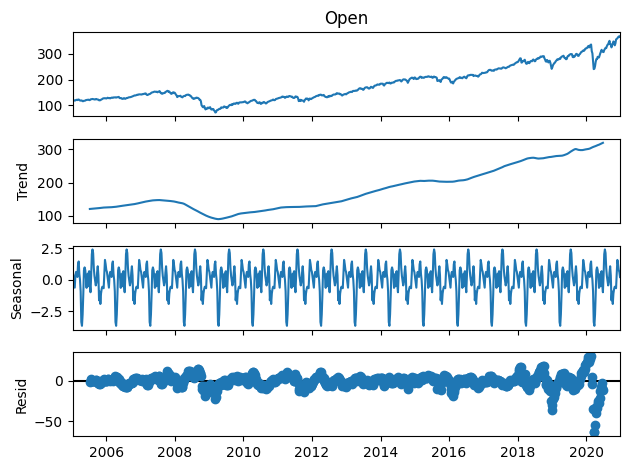

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1, model='additive', period=52)
result.plot()

Using the Augmented Dickey-Fuller and KPSS tests to check for stationality

In [25]:
from arch.unitroot import KPSS, ADF
ADF(df1)

Test Statistic,1.325
P-value,0.997
Lags,9


In [28]:
from pmdarima.arima.utils import ndiffs
ndiffs(df1, test='adf')

1

STLForecast wrapper that removes seasonality and adds it back in. This is necessary since ARIMA can't handle seasonality out of the box:

In [32]:
mod = sm.tsa.arima.ARIMA(endog=df1, order=(1, 0, 0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  834
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2257.821
Date:                Sun, 24 Dec 2023   AIC                           4521.642
Time:                        10:08:30   BIC                           4535.821
Sample:                    01-09-2005   HQIC                          4527.078
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        182.3710    319.306      0.571      0.568    -443.456     808.198
ar.L1          0.9996      0.002    632.859      0.000       0.996       1.003
sigma2        13.0418      0.218     59.826      0.0

/Users/quangtn/opt/anaconda3/envs/timeseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [39]:
from statsmodels.tsa.forecasting.stl import STLForecast
mod = STLForecast(
    df1, sm.tsa.arima.ARIMA,
    model_kwargs=dict(order=(1, 1, 0), trend="t")
)
res = mod.fit().model_result
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1965.555
Date:                Sun, 24 Dec 2023   AIC                           3937.110
Time:                        10:27:12   BIC                           3951.285
Sample:                    01-09-2005   HQIC                          3942.545
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2771      0.119      2.327      0.020       0.044       0.511
ar.L1          0.2502      0.022     11.402      0.000       0.207       0.293
sigma2         6.5618      0.184     35.641      0.0

In [33]:
STEPS=20
forecasts_df=res.get_forecast(steps=STEPS).summary_frame()

In [35]:
forecasts_df.head()

Open,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-03,367.302012,3.611339,360.223919,374.380106
2021-01-10,367.219067,5.106059,357.211376,377.226759
2021-01-17,367.136159,6.252217,354.882039,379.390280
2021-01-24,367.053289,7.217820,352.906621,381.199957
2021-01-31,366.970455,8.067960,351.157545,382.783366


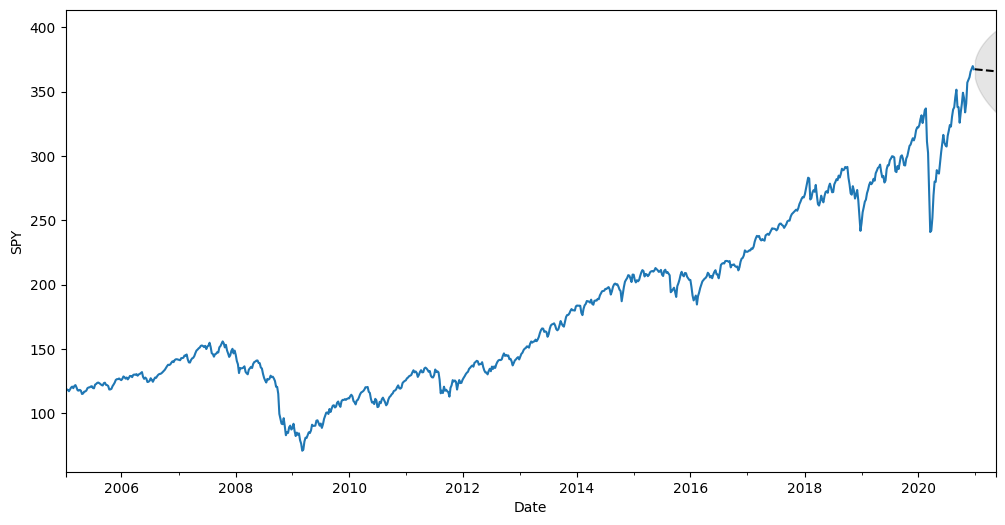

In [37]:
ax=df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts_df['mean'].plot(style='k--')
ax.fill_between(
    forecasts_df.index,
    forecasts_df['mean_ci_lower'],
    forecasts_df['mean_ci_upper'],
    color='k',
    alpha=0.1
)

Create difference models to see the difference in their forecasts

In [55]:
import pandas as pd
forecasts=[]
qs=[]
for q in range(0, 30, 10):
    mod=STLForecast(
        df1, sm.tsa.arima.ARIMA,
        model_kwargs=dict(order=(0, 1, q), trend="t")
    )
    res=mod.fit()
    forecasts.append(
        res.forecast(STEPS)
    )
    qs.append(q)

forecast_df=pd.concat(forecasts, axis=1)
forecast_df.columns=qs

<Axes: xlabel='Date', ylabel='SPY'>

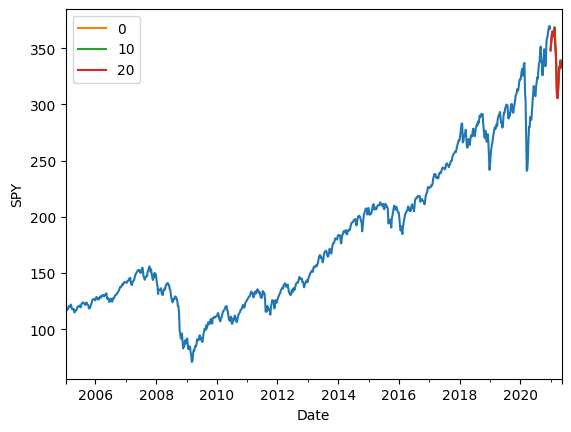

In [56]:
ax = df1.plot()
plt.ylabel('SPY')
forecast_df.plot(ax=ax)

the order of 10 give us the lowest AIC, and according to this criterion, we should therefore choose q=10.

## Exponential smoothing model

In [57]:
mod = sm.tsa.ExponentialSmoothing(
    endog=df1, trend='add'
)
res = mod.fit()

In [61]:
STEPS=20
forecasts = pd.Series(res.forecast(steps=STEPS))

<Axes: ylabel='SPY'>

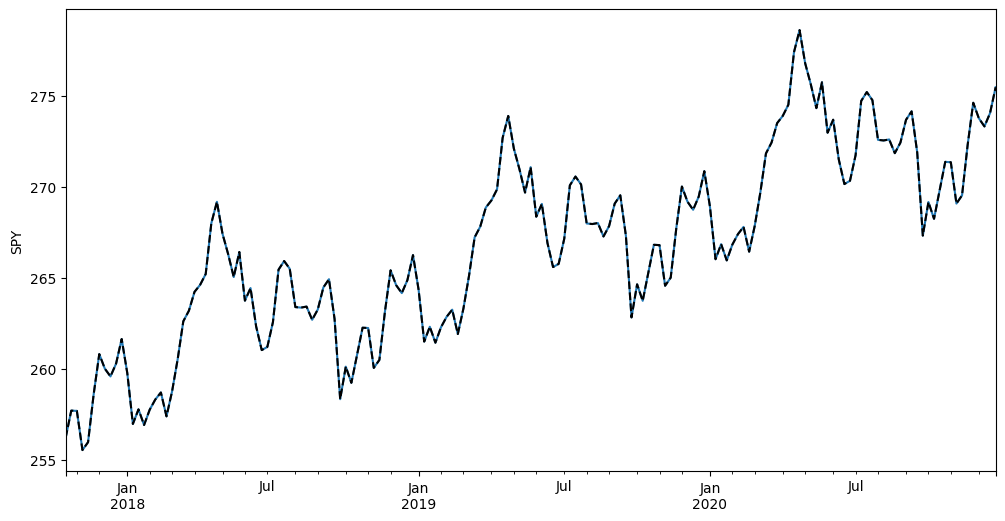

In [66]:
ax = forecasts.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts.plot(style='k--')

In [63]:
from statsmodels.tsa.forecasting.theta import ThetaModel
train_length=int(len(df1)*0.8)
tm=ThetaModel(df1[:train_length], method="auto",deseasonalize=True)

<Axes: xlabel='Date', ylabel='SPY'>

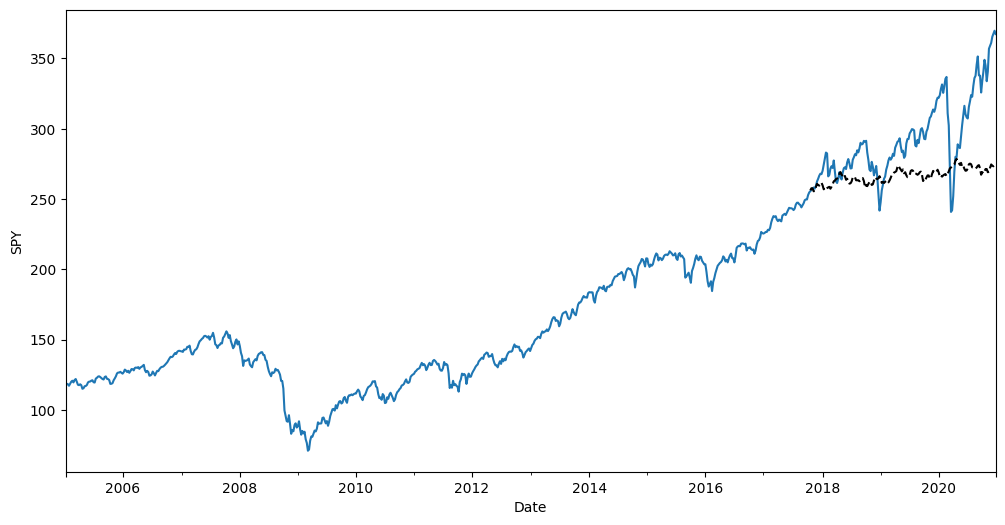

In [65]:
res=tm.fit()
forecasts=res.forecast(steps=len(df1)-train_length)
ax=df1.plot(figsize=(12, 6))
plt.ylabel('SPY')
forecasts.plot(style='k--')

In [67]:
from sklearn import metrics
metrics.mean_squared_error(forecasts, df1[train_length:], squared=False)

37.03323186348075